In [1]:
!pip install sentence_transformers
!pip install samplesizelib

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import time
import os

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.models import RegressionModel

from torchvision import datasets
from torchvision import transforms

# Homework
**Task** : Использовать модель для векторизации предложений из семинара. На основе полученных векторов решить задачу сентимент анализа для выборки Twitter (задача бинарной классификации). В качестве модели рассмотреть логистическую регрессию. Рекомендуется использовать модель Perceptron с третьего семинара, а также функцию ошибки torch.nn.BCELoss. 

# Данные


In [4]:
# data = pd.read_csv("data/Sentiment Analysis Dataset.csv", error_bad_lines=False)

# data.head(5)

In [5]:
# x, y = data.SentimentText, data.Sentiment # for now we will take only 1% of original dataset due to computation difficulties

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# x_train.shape, x_test.shape

In [6]:
# Sentences to vectors

# vectorizer = SentenceTransformer('LaBSE', device='cuda', cache_folder='vectorizer_params/')
# X_train = vectorizer.encode(x_train.to_list())
# X_test = vectorizer.encode(x_test.to_list())

# Y_train = y_train.to_numpy().astype(np.byte)
# Y_test = y_test.to_numpy().astype(np.byte)

# # save to files

# np.save(file='data/train_vectors_full', arr=X_train.astype(np.float16))
# np.save(file='data/test_vectors_full', arr=X_test.astype(np.float16))

# np.save(file='data/target_train_full', arr=Y_train)
# np.save(file='data/target_test_full', arr=Y_test)

In [7]:
X_train = np.load("data/train_vectors_full.npy")
X_test = np.load("data/test_vectors_full.npy")

Y_train = np.load('data/target_train_full.npy')
Y_test = np.load('data/target_test_full.npy')

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1262889, 768), (315723, 768), (1262889,), (315723,))

In [8]:
Y_train.dtype, Y_test.dtype

(dtype('int8'), dtype('int8'))

По-хорошему мы должны были бы использовать K-Fold, чтобы получить объективную оценку качества и отобрать гиперпараметры, а затем измериить качество работы на тесте. Однако, мы имеем дело с достаточно большим датасетом (1.2 М train и 0.3 M тест). K-Fold на выборке такого размера даже при небольшой архитектуре займет много времени. Поэтому мы будем использовать обычный train/val split. В силу размера выборки, оценка качества и при таком подходе должна быть достаточно объективной.

In [25]:
x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, Y_train, test_size=0.1)


x_train_fold = torch.Tensor(x_train_fold)
x_val_fold = torch.Tensor(x_val_fold)
y_train_fold = torch.FloatTensor(y_train_fold)
y_val_fold = torch.FloatTensor(y_val_fold)

traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
valdata = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.FloatTensor(Y_test))

x_train_fold.shape, x_val_fold.shape

(torch.Size([1136600, 768]), torch.Size([126289, 768]))

## Model side

В качестве модели рассмотрим перцептрон из семинара 3.

In [10]:
INPUT_DIM = 768

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [12]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=INPUT_DIM, num_layers=0, 
                 hidden_dim=100, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [13]:
from IPython.display import clear_output


def testing_binary(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=51200)

    pred = []
    real = []
    for x, y in generator:
        x = x.to(device)

        pred.extend((model(x).squeeze() >= 0).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)


def trainer(model, dataset, loss_function, optimizer, epochs, val_data=None):
    loss_history = []
    acc_history = []
    
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=51200, 
                                              shuffle=True)
        
        model.train()
        for x, y in generator:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.data.cpu().numpy())
        
        model.eval()
        acc, _ = testing_binary(model, val_data)
        acc_history.append(acc)
        clear_output(True)

        # print intermediate results
        plt.subplots(1, 2)
        
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
    
        plt.subplot(1, 2, 2)
        plt.plot(acc_history)
        
        time.sleep(0.1)
        plt.pause(0.0001)

В силу опять же большой выборки, неплохо иметь априорное представление о том, что мы получим на выходе перед hyperparameter tuning. Для этого мы воспользуемся baseline моделью, гиперпараметры которой выбраны умозрительно.

In [11]:
baseline_model = Perceptron(hidden_dim=200, num_layers=5, p=0.1).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-4)

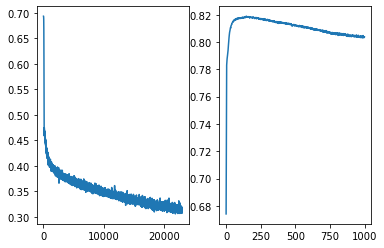

In [12]:
baseline_model.train()

trainer(baseline_model,
        traindata,
        torch.nn.BCEWithLogitsLoss(),
        optimizer,
        epochs=1000,
        val_data=valdata)

In [13]:


acc, report = testing_binary(baseline_model, test_dataset)

In [14]:
acc

0.8024787551112843

In [17]:
# save model weights
baseline_model.eval()
torch.save(baseline_model.state_dict(), "models/baseline.pth")

**Замечание:** видно, что качество на тесте хорошо совпадает с качеством на валидационной выборке. Таким образом, предположение о достаточности простой валидации обосновано.

Из графиков выше и полученного качества можно сделать следующие выводы:
- Делать сеть глубже или шире смысла нет, так как несмотря на объем выборки, она все равно переобучается.
- Количество эпох не имеет смысла делать больше 200, далее модель начинает переобучаться.
- lr подобран оптимально, модель и не учится слишком быстро, и не слишком медленно.
- dropout можно увеличить.

### Cross val и grid search
Делать глубокий grid search смысла нет в силу большого времени. Поэтому мы немного поэкспериментируем с шириной сети и параметром **p** у Dropout, а остальные параметры (кроме количества эпох) оставим теми же.

In [14]:
param_grid = ParameterGrid(
    {'hid_dim': [200, 250],
    'p': [0.3, 0.6]})

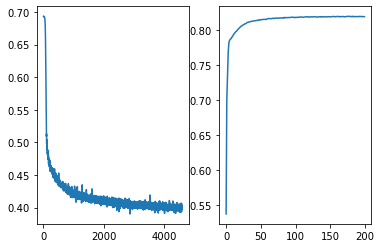

In [15]:
for item in tqdm(param_grid):    
    model = Perceptron(input_dim=INPUT_DIM, hidden_dim=item['hid_dim'], num_layers=5, p=item['p']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
    trainer(model, traindata, torch.nn.BCEWithLogitsLoss(), optimizer, epochs=200, val_data=valdata)
    
    torch.save(model.state_dict(), f"models/perc_hid_dim_{item['hid_dim']}_p_{item['p']}")

Теперь оценим качество каждой из имеющихся моделей.

In [21]:
path = "models/"
# model_names = os.listdir(path)
model_names = ['baseline.pth',
 'perc_hid_dim_200_p_0.3.pth',
 'perc_hid_dim_200_p_0.6.pth',
 'perc_hid_dim_250_p_0.3.pth',
 'perc_hid_dim_250_p_0.6.pth']

In [28]:
accs = {}

for name in model_names:
    if '250' in name:
        model = Perceptron(input_dim=INPUT_DIM, hidden_dim=250, num_layers=5).to(device)
    else:
        model = Perceptron(input_dim=INPUT_DIM, hidden_dim=200, num_layers=5).to(device)
    
    model.load_state_dict(torch.load(path + name))
    model.eval()
    
    acc, _ = testing_binary(model, valdata)
    
    accs[name] = acc

In [29]:
accs

{'baseline.pth': 0.8807655456928157,
 'perc_hid_dim_200_p_0.3.pth': 0.8369295821488807,
 'perc_hid_dim_200_p_0.6.pth': 0.8295021735859813,
 'perc_hid_dim_250_p_0.3.pth': 0.8405245112400922,
 'perc_hid_dim_250_p_0.6.pth': 0.8310541694050947}

In [39]:
best_model = Perceptron(input_dim=INPUT_DIM, hidden_dim=250, num_layers=5).to(device)
best_model.load_state_dict(torch.load('models/perc_hid_dim_250_p_0.3.pth'))

best_model.eval()
acc, report = testing_binary(best_model, test_dataset)
print(f"best_accuracy = {acc}\n", report)

best_accuracy = 0.8170579907070439
               precision    recall  f1-score   support

         0.0       0.82      0.81      0.82    158085
         1.0       0.81      0.82      0.82    157638

    accuracy                           0.82    315723
   macro avg       0.82      0.82      0.82    315723
weighted avg       0.82      0.82      0.82    315723



Как видно, лучшая модель превзошла baseline на почти на 2%, что очень даже неплохо. Лучший результат на валидационной выборке показала модель с **p=0.3** и **hid_dim=250**, то есть модель с лучшей обобщающей способностью (и наиболее склонная к overfitting'у).

Стоит отметить, что все-таки результат на тесте и валидации немного отличаются -- мы "подогнали" модели под валидационную выборку. Однако отличие не очень большое, так что в целом алгоритм можно считать валидным.

**P.S.** не могу сказать, с чем связано столь высокое качество baseline на валидации (0.88). Скорее всего, это связано с перезапуском процесса обучения и изменением разбиения на train/val. Однако разбиение Train/Test было постоянным, и конечный результат на тесте можно считать валидным.